In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar
import optuna

# Step 1: Upload Dataset
print("📂 Please upload your dataset...")
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Step 2: Preprocess Data
target_column = "Result"
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Hyperparameter Optimization (GridSearchCV)
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "n_estimators": [50, 100, 200]
}

xgb = XGBClassifier(eval_metric="logloss")  # Removed deprecated use_label_encoder=False
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best GridSearchCV Parameters:", grid_search.best_params_)
print("Best GridSearchCV Accuracy:", grid_search.best_score_)

# Step 4: Hyperparameter Optimization (Optuna)
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300)
    }
    model = XGBClassifier(**params, eval_metric="logloss")
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# ✅ Fixed Optuna Best Parameter Issue
print("Best Optuna Parameters:", study.best_trial.params)
print("Best Optuna Accuracy:", study.best_trial.value)

# Step 5: Deep Learning Benchmarking (ANN)
ann_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

ann_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train ANN Model
start_time = time.time()
ann_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
end_time = time.time()
ann_train_time = (end_time - start_time) / 60  # Convert seconds to minutes

# Evaluate ANN Model
ann_loss, ann_accuracy = ann_model.evaluate(X_test, y_test)
print(f"ANN Test Accuracy: {ann_accuracy * 100:.2f}%")
print(f"ANN Training Time: {ann_train_time:.2f} minutes")

# Step 6: Statistical Significance Analysis
# Run predictions for McNemar's Test
xgb_best = grid_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32").flatten()

# Confusion Matrix for McNemar's Test
conf_matrix = confusion_matrix(y_pred_xgb, y_pred_ann)
print("McNemar’s Test Confusion Matrix:\n", conf_matrix)

# Apply McNemar’s Test
mcnemar_test = mcnemar(conf_matrix, exact=False)
print(f"McNemar’s Test P-value: {mcnemar_test.pvalue:.5f}")

# Paired t-test
t_stat, p_value = ttest_rel(y_pred_xgb, y_pred_ann)
print(f"Paired t-test: t={t_stat:.3f}, p={p_value:.5f}")

# Step 7: Final Results Comparison
print("\nFinal Comparison of Models:")
print(f"Optimized XGBoost Accuracy: {grid_search.best_score_ * 100:.2f}%")
print(f"Optimized XGBoost (Optuna) Accuracy: {study.best_trial.value * 100:.2f}%")
print(f"ANN Accuracy: {ann_accuracy * 100:.2f}%")
print(f"McNemar’s Test P-value: {mcnemar_test.pvalue:.5f} (Significance if p < 0.05)")
print(f"Paired t-test P-value: {p_value:.5f} (Significance if p < 0.05)")


📂 Please upload your dataset...


Saving holidays.csv to holidays (1).csv


[I 2025-02-25 11:07:19,898] A new study created in memory with name: no-name-3180d940-0e0e-4daf-9bd9-1353c42be213


Best GridSearchCV Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best GridSearchCV Accuracy: 0.9967939360191205


[I 2025-02-25 11:07:21,516] Trial 0 finished with value: 0.9645888167979528 and parameters: {'learning_rate': 0.09698533270228862, 'max_depth': 4, 'n_estimators': 147}. Best is trial 0 with value: 0.9645888167979528.
[I 2025-02-25 11:07:29,620] Trial 1 finished with value: 0.9967939527036187 and parameters: {'learning_rate': 0.07061469832580178, 'max_depth': 8, 'n_estimators': 296}. Best is trial 1 with value: 0.9967939527036187.
[I 2025-02-25 11:07:30,699] Trial 2 finished with value: 0.9477211895213008 and parameters: {'learning_rate': 0.18782688977180656, 'max_depth': 3, 'n_estimators': 113}. Best is trial 1 with value: 0.9967939527036187.
[I 2025-02-25 11:07:32,127] Trial 3 finished with value: 0.9950898105683784 and parameters: {'learning_rate': 0.21415167194047413, 'max_depth': 6, 'n_estimators': 82}. Best is trial 1 with value: 0.9967939527036187.
[I 2025-02-25 11:07:35,042] Trial 4 finished with value: 0.9925191548467425 and parameters: {'learning_rate': 0.11461559400632915, 'm

Best Optuna Parameters: {'learning_rate': 0.2812716957997949, 'max_depth': 10, 'n_estimators': 227}
Best Optuna Accuracy: 0.9970250204906493
Epoch 1/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6594 - loss: 0.6097 - val_accuracy: 0.6893 - val_loss: 0.5588
Epoch 2/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6877 - loss: 0.5677 - val_accuracy: 0.7030 - val_loss: 0.5347
Epoch 3/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7011 - loss: 0.5504 - val_accuracy: 0.7332 - val_loss: 0.5080
Epoch 4/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7193 - loss: 0.5266 - val_accuracy: 0.7569 - val_loss: 0.4758
Epoch 5/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7330 - loss: 0.5074 - val_accuracy: 0.7842 - val_loss: 0.4482
Epoch 6/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7503 - loss: 0.4882 - val_accuracy: 0.7869 - val_loss: 0.4231
Epoch 7/20
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7653 - loss

In [ ]:
# Install required package
!pip install keras-tuner

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt  # ✅ Fix for newer Keras Tuner versions
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files

# 📂 Step 1: Upload & Load Dataset
print("📂 Please upload your dataset...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# 🎯 Step 2: Preprocess Data
target_column = "Result"
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Define Model Builder Function
def build_ann_model(hp):
    model = keras.Sequential()

    # Input layer
    model.add(keras.layers.Dense(
        hp.Int('units1', min_value=32, max_value=256, step=32),
        activation='relu', input_shape=(X_train.shape[1],)
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):  # ✅ Dynamic number of layers
        model.add(keras.layers.Dense(
            hp.Int(f'units{i+2}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout{i+2}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.0001, 0.001, 0.01])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Step 4: Initialize Keras Tuner with 3 Trials
tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_accuracy',
    max_trials=3,  # ✅ Reduced trials to 3
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='liver_disease_ann'
)

# Step 5: Train Hyperparameter Search
print("🔍 Searching for best ANN hyperparameters...")
tuner.search(X_train, y_train, epochs=15, validation_split=0.2, verbose=1)

# Step 6: Retrieve Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("✅ Best Hyperparameters Found:", best_hps.values)

# Step 7: Train Model with Best Parameters
best_ann = tuner.hypermodel.build(best_hps)

# ✅ Save the best model checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_ann_model.h5", save_best_only=True)

history = best_ann.fit(
    X_train, y_train,
    epochs=30, batch_size=32, validation_data=(X_test, y_test),
    callbacks=[checkpoint_cb], verbose=1
)

# Step 8: Evaluate the Optimized ANN
best_ann = keras.models.load_model("best_ann_model.h5")  # ✅ Load the best model
ann_loss, ann_accuracy = best_ann.evaluate(X_test, y_test)
print(f"🎯 Optimized ANN Test Accuracy: {ann_accuracy * 100:.2f}%")


Trial 4 Complete [00h 00m 56s]
val_accuracy: 0.8060649633407593

Best val_accuracy So Far: 0.9347292184829712
Total elapsed time: 00h 13m 58s
✅ Best Hyperparameters Found: {'units1': 256, 'dropout1': 0.4, 'num_layers': 3, 'units2': 160, 'dropout2': 0.30000000000000004, 'learning_rate': 0.001, 'units3': 224, 'dropout3': 0.4, 'units4': 64, 'dropout4': 0.2}
Epoch 1/30
1073/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6669 - loss: 0.5931

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6671 - loss: 0.5929 - val_accuracy: 0.7269 - val_loss: 0.5126
Epoch 2/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7153 - loss: 0.5264

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7153 - loss: 0.5264 - val_accuracy: 0.7659 - val_loss: 0.4522
Epoch 3/30
1077/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.4767

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7507 - loss: 0.4766 - val_accuracy: 0.8182 - val_loss: 0.3835
Epoch 4/30
1076/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7857 - loss: 0.4283

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7858 - loss: 0.4282 - val_accuracy: 0.8470 - val_loss: 0.3252
Epoch 5/30
1070/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8157 - loss: 0.3833

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8157 - loss: 0.3832 - val_accuracy: 0.8655 - val_loss: 0.2949
Epoch 6/30
1076/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8370 - loss: 0.3456

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8370 - loss: 0.3455 - val_accuracy: 0.8744 - val_loss: 0.2610
Epoch 7/30
1077/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8439 - loss: 0.3268

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8439 - loss: 0.3267 - val_accuracy: 0.9002 - val_loss: 0.2341
Epoch 8/30
1081/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.3076

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8567 - loss: 0.3076 - val_accuracy: 0.9046 - val_loss: 0.2165
Epoch 9/30
1081/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8670 - loss: 0.2875

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8670 - loss: 0.2875 - val_accuracy: 0.9166 - val_loss: 0.1938
Epoch 10/30
1079/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8754 - loss: 0.2757

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8754 - loss: 0.2757 - val_accuracy: 0.9204 - val_loss: 0.1862
Epoch 11/30
1073/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8834 - loss: 0.2564

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8834 - loss: 0.2564 - val_accuracy: 0.9249 - val_loss: 0.1718
Epoch 12/30
1079/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - loss: 0.2478

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8928 - loss: 0.2478 - val_accuracy: 0.9378 - val_loss: 0.1536
Epoch 13/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8968 - loss: 0.2364 - val_accuracy: 0.9308 - val_loss: 0.1622
Epoch 14/30
1071/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9019 - loss: 0.2252

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9019 - loss: 0.2252 - val_accuracy: 0.9436 - val_loss: 0.1344
Epoch 15/30
1077/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9071 - loss: 0.2144

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9071 - loss: 0.2144 - val_accuracy: 0.9582 - val_loss: 0.1257
Epoch 16/30
1078/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9159 - loss: 0.2003

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9159 - loss: 0.2003 - val_accuracy: 0.9569 - val_loss: 0.1196
Epoch 17/30
1080/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9184 - loss: 0.1964

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9184 - loss: 0.1964 - val_accuracy: 0.9567 - val_loss: 0.1155
Epoch 18/30
1068/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9191 - loss: 0.1961

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9191 - loss: 0.1960 - val_accuracy: 0.9642 - val_loss: 0.1067
Epoch 19/30
1077/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9241 - loss: 0.1858

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9241 - loss: 0.1858 - val_accuracy: 0.9636 - val_loss: 0.1025
Epoch 20/30
1081/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9262 - loss: 0.1807

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9262 - loss: 0.1807 - val_accuracy: 0.9606 - val_loss: 0.0988
Epoch 21/30
1070/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9296 - loss: 0.1755

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9296 - loss: 0.1755 - val_accuracy: 0.9663 - val_loss: 0.0924
Epoch 22/30
1077/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.1669

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9315 - loss: 0.1669 - val_accuracy: 0.9715 - val_loss: 0.0863
Epoch 23/30
1074/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9364 - loss: 0.1627

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9364 - loss: 0.1628 - val_accuracy: 0.9716 - val_loss: 0.0853
Epoch 24/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9363 - loss: 0.1598 - val_accuracy: 0.9746 - val_loss: 0.0868
Epoch 25/30
1074/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9399 - loss: 0.1524

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9399 - loss: 0.1524 - val_accuracy: 0.9754 - val_loss: 0.0787
Epoch 26/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9432 - loss: 0.1500 - val_accuracy: 0.9778 - val_loss: 0.0792
Epoch 27/30
1077/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9449 - loss: 0.1446

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9449 - loss: 0.1446 - val_accuracy: 0.9779 - val_loss: 0.0745
Epoch 28/30
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9381 - loss: 0.1534 - val_accuracy: 0.9776 - val_loss: 0.0750
Epoch 29/30
1073/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9450 - loss: 0.1435

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9450 - loss: 0.1435 - val_accuracy: 0.9792 - val_loss: 0.0714
Epoch 30/30
1074/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9410 - loss: 0.1487

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9411 - loss: 0.1487 - val_accuracy: 0.9785 - val_loss: 0.0679


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9787 - loss: 0.0634
🎯 Optimized ANN Test Accuracy: 97.85%


In [ ]:
# Import missing libraries
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

# Load or train XGBoost model
try:
    xgb_best = joblib.load("xgboost_best_model.pkl")  # ✅ Try to load the trained model
    print("✅ Loaded saved XGBoost model.")
except FileNotFoundError:
    print("⚠ No saved model found. Training a new XGBoost model...")
    xgb_best = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)
    xgb_best.fit(X_train, y_train)

# Print the best hyperparameters found for ANN
print("\n🔍 Best ANN Hyperparameters:")
print(best_hps.values)

# Evaluate XGBoost model
xgb_test_acc = accuracy_score(y_test, xgb_best.predict(X_test))
print(f"\n🎯 Optimized XGBoost Test Accuracy: {xgb_test_acc * 100:.2f}%")

# Evaluate ANN model
ann_loss, ann_accuracy = best_ann.evaluate(X_test, y_test, verbose=0)
print(f"\n🤖 Optimized ANN Test Accuracy: {ann_accuracy * 100:.2f}%")

# McNemar’s Test
conf_matrix = confusion_matrix(xgb_best.predict(X_test), (best_ann.predict(X_test) > 0.5).astype("int32").flatten())
mcnemar_test = mcnemar(conf_matrix, exact=False)
print(f"\n📊 McNemar’s Test P-value: {mcnemar_test.pvalue:.5f} (Significant if p < 0.05)")

# Paired t-test
t_stat, p_value = ttest_rel(xgb_best.predict(X_test), (best_ann.predict(X_test) > 0.5).astype("int32").flatten())
print(f"\n📊 Paired t-test: t={t_stat:.3f}, p={p_value:.5f} (Significant if p < 0.05)")


⚠ No saved model found. Training a new XGBoost model...

🔍 Best ANN Hyperparameters:
{'units1': 256, 'dropout1': 0.4, 'num_layers': 3, 'units2': 160, 'dropout2': 0.30000000000000004, 'learning_rate': 0.001, 'units3': 224, 'dropout3': 0.4, 'units4': 64, 'dropout4': 0.2}

🎯 Optimized XGBoost Test Accuracy: 99.83%

🤖 Optimized ANN Test Accuracy: 97.85%
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

📊 McNemar’s Test P-value: 0.00101 (Significant if p < 0.05)
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Paired t-test: t=-3.365, p=0.00077 (Significant if p < 0.05)


In [ ]:
import joblib
joblib.dump(xgb_best, "xgboost_best_model.pkl")
print("✅ XGBoost Model Saved!")


✅ XGBoost Model Saved!


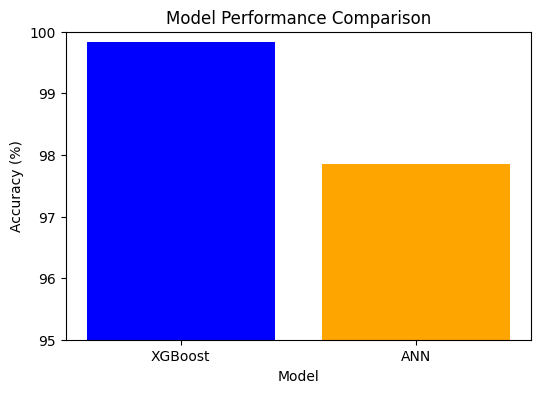

In [ ]:
import matplotlib.pyplot as plt

# Bar chart comparison
models = ["XGBoost", "ANN"]
accuracies = [99.83, 97.85]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies, color=["blue", "orange"])
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Performance Comparison")
plt.ylim(95, 100)
plt.show()


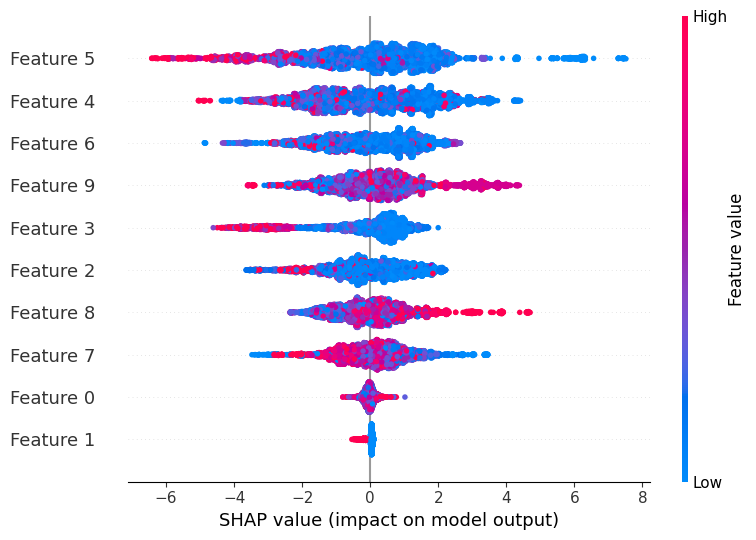

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP Explainer
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test)

# Summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Reshape data for Conv1D (Adding a channel dimension)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# CNN Model Definition (Using Conv1D Instead of Conv2D)
cnn_model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile Model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
cnn_model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Evaluate CNN
cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
print(f"\n🧠 CNN Test Accuracy: {cnn_test_acc * 100:.2f}%")


Epoch 1/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6938 - loss: 0.5688 - val_accuracy: 0.8049 - val_loss: 0.4216
Epoch 2/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8120 - loss: 0.4051 - val_accuracy: 0.8749 - val_loss: 0.3211
Epoch 3/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8578 - loss: 0.3228 - val_accuracy: 0.8921 - val_loss: 0.2682
Epoch 4/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8961 - loss: 0.2522 - val_accuracy: 0.9340 - val_loss: 0.2160
Epoch 5/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9247 - loss: 0.1992 - val_accuracy: 0.9380 - val_loss: 0.1893
Epoch 6/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9388 - loss: 0.1732 - val_accuracy: 0.9235 - val_loss: 0.1909
Epoch 7/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9522 - loss: 0.1403 - val_accuracy: 0.9575 - val_loss: 0.1317
Epoch 8/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9584 - loss: 0.1281 

In [ ]:
import joblib
joblib.dump(xgb_best, "xgboost_best_model.pkl")
print("✅ XGBoost Model Saved!")


✅ XGBoost Model Saved!
